In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import datetime, os, pickle
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.3.0


In [3]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, BatchNormalization, Reshape, Dropout, Activation
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, normalize, plot_model

# Table of contents
1. [Data Description](#data)
2. [Visualizations](#vis)
3. [On why we need an embedding layer](#emb)
3. [Defining the PitchNet model with the Keras Functional API](#model)  
4. [Preparing the data](#prep)
5. [Compiling and fitting the model](#compile)
6. [Grid search for best structure](#grid)
7. [Conclusion](#con)

# Data Description <a name="data"></a>

In [4]:
baseball = pd.read_parquet('pitch_prediction_data.parquet')

In [5]:
baseball.shape

(3609510, 12)

The raw data is scraped from the baseball website [Savant](https://baseballsavant.mlb.com/), and includes all pitch-by-pitch data from 2014 to 2019. The data cleaning step (using pyspark) is in the pitchnet_data_prep_spark.ipynb file. I have also simplified the raw data by keeping the most common 9 pitch types. The glossary of MLB pitch types could be found [here](https://www.daktronics.com/support/kb/Pages/DD3312647.aspx).

There are 3 continuous predictors we will feed into the classification neural network: the release speed, horizontal break, and vertical break. <br>
The target variable is pitch_type.

In [6]:
baseball.head()

,pitch_type,game_date,pitcher,p_throws,player_name,horizontal_break,vertical_break,release_speed,game_year,game_month,idx,season_total_pitches
0,FT,2017-07-15,425492,R,Ryan Madson,-1.215253,0.993840,96.1,2017,7,42949705907,928
1,FT,2017-07-15,425492,R,Ryan Madson,-1.293081,0.910183,95.9,2017,7,42949705908,928
2,FT,2017-07-15,425492,R,Ryan Madson,-1.190779,0.684373,94.2,2017,7,42949705909,928
3,FT,2017-07-15,425492,R,Ryan Madson,-1.344454,0.505213,94.7,2017,7,42949705910,928
4,FF,2017-07-15,425492,R,Ryan Madson,-1.163491,1.020095,94.8,2017,7,42949705911,928


In [7]:
n_pitcher = np.unique(baseball.pitcher).shape[0]
print('Number of pitchers: {}'.format(n_pitcher))

n_pitch_type = np.unique(baseball.pitch_type).shape[0]
print('Number of pitch types: {}'.format(n_pitch_type))
print('Included pitch types: {}'.format(np.unique(baseball.pitch_type)))

Number of pitchers: 1523
Number of pitch types: 9
Included pitch types: ['CH' 'CU' 'FC' 'FF' 'FS' 'FT' 'KC' 'SI' 'SL']


# Visualizations <a name="vis"></a>

In [8]:
sns.set(rc={'figure.figsize':(10,6.5)})

In [28]:
# generate a small sample of the data
samp = baseball.sample(frac = 0.3, random_state=1)

### Boxenplot of the release speed:

Some pitches have a very similar distribution of release speed, i.e. FF (four-seam fastball), FT (two-seam fastball), SI (sinker).

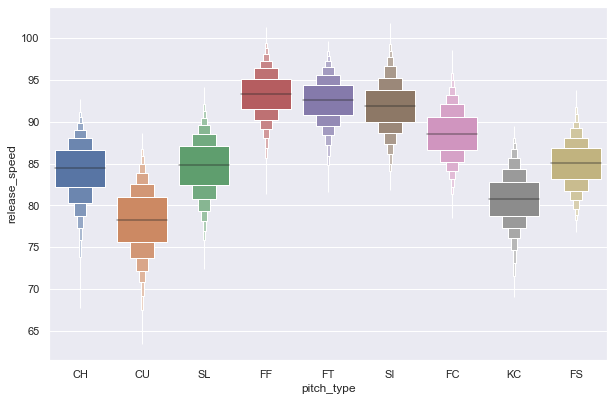

In [29]:
sns.boxenplot(x="pitch_type", y="release_speed", data=samp, showfliers = False)

### Boxenplot of the vertical break:

FF (four-seam fastball) seems to be distinguishable from other fastballs if we look at the vertical break.

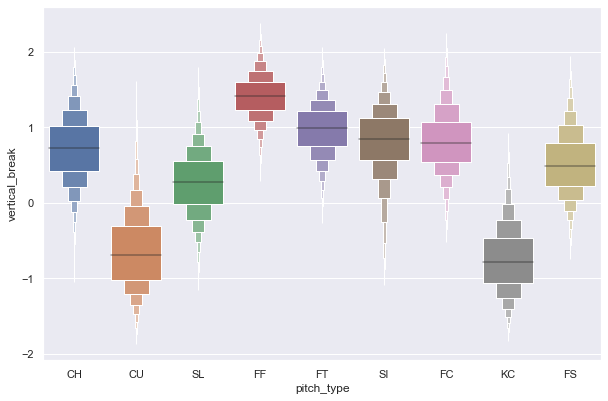

In [11]:
sns.boxenplot(x="pitch_type", y="vertical_break", data=samp, showfliers = False)

### Boxenplot of the horizontal break:

The horizontal break would have opposite signs for left-handed and right-handed pitchers:

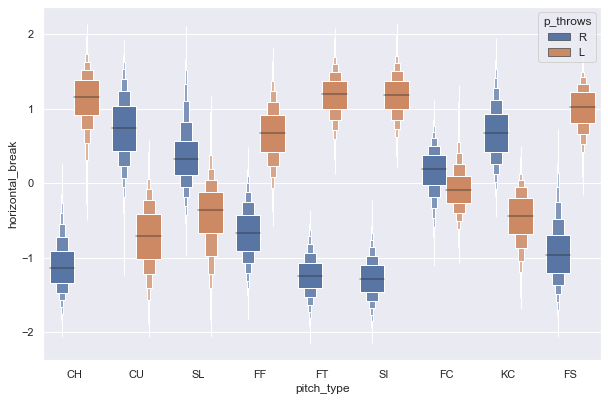

In [12]:
sns.boxenplot(x="pitch_type", y="horizontal_break", hue = 'p_throws', data=samp, showfliers = False)

### 3D scatterplot of release speed, vertical break, and horizontal break.

Here I computed the average release speed, vertical break, and horizontal break for each pitch type for each pitcher.

In [19]:
arsenal = baseball.groupby(['player_name','pitch_type','p_throws']).agg({'vertical_break':'mean', 'horizontal_break':'mean','release_speed':'mean'}).reset_index()

In [24]:
arsenal_samp = arsenal.sample(frac = 0.3, random_state = 0)

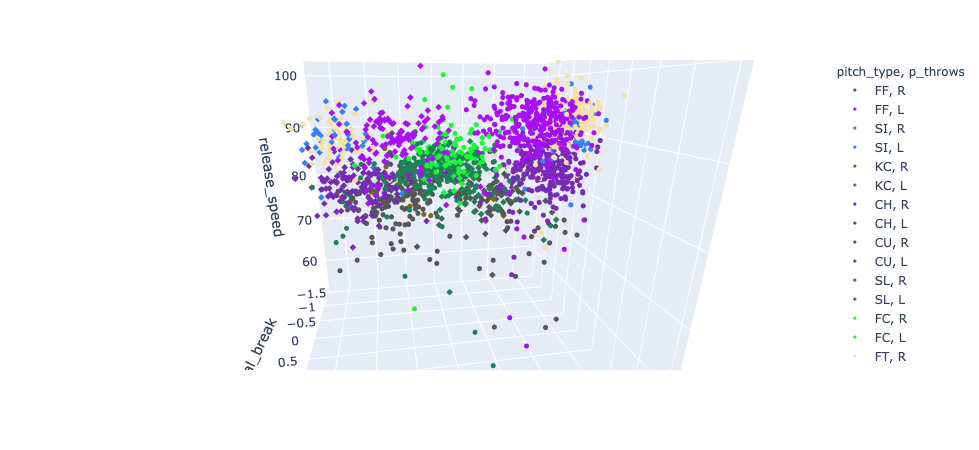

In [25]:
fig = px.scatter_3d(arsenal_samp, x='horizontal_break', y='vertical_break', z='release_speed',
              color='pitch_type',symbol ='p_throws',hover_name='player_name',color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_traces(marker=dict(size=3))
fig.show()

# On why we need an embedding layer for the NN <a name="emb"></a>

Different pitchers could have very different pitching profiles, which could cause problems when classifying the pitches. The density plot of release speed below demonstrates this issue. For example, the pitcher Ryan Yarbrough has a cutter (FC) around 85mph, while the pitcher Tyler Glasnow has his slider (SL) in the similar range. Having an embedding layer allows us to encode pitcher information into our network.

### Release Speed: Tyler Glasnow v.s. Ryan Yarbrough

Text(0.5, 1.05, 'Release Speed of different pitch types')

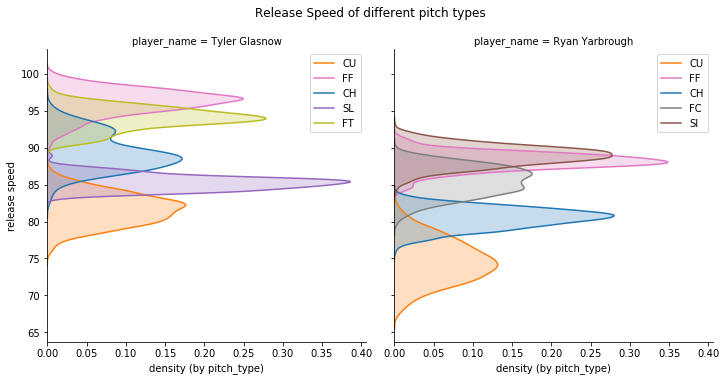

In [47]:
comparison = baseball[(baseball.player_name == 'Ryan Yarbrough') | (baseball.player_name == 'Tyler Glasnow')]
pitch_palette = dict(zip(['CH','CU','FS','KC','SL','SI','FF','FC','FT'], ['C{}'.format(i) for i in range(0,9)]))
g = sns.FacetGrid(comparison,col = 'player_name', hue='pitch_type', palette=pitch_palette, height=5)
g = (g.map(sns.distplot, 'release_speed', hist=False, kde_kws={"shade": True}, vertical=True).set_axis_labels("density (by pitch_type)", "release speed"))
for ax in g.axes.ravel():
    ax.legend()
g.fig.suptitle('Release Speed of different pitch types', y=1.05)

### Horizontal Break: Tyler Glasnow v.s. Ryan Yarbrough

The density plot below shows the horizontal break of different pitch types. Again, the plot shows that it is hard to distinguish between Yarbrough's cutter (FC) and Glasnow's slider (SL). Note that since Glasnow is right-handed and Yarbrough is left-handed, the signs (for the same pitch type) would likely to be opposite.

Text(0.5, 1.05, 'Horizontal Break of different pitch types')

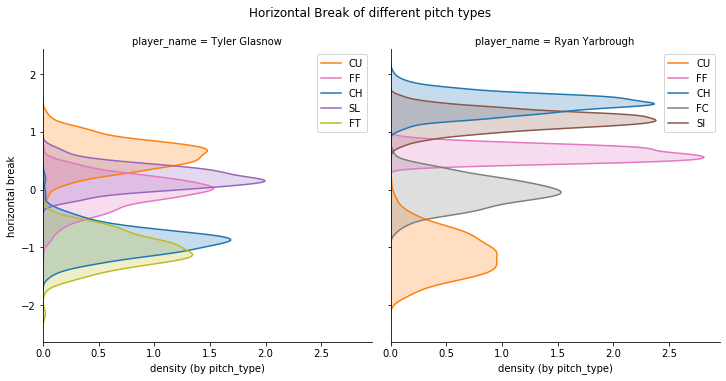

In [41]:
comparison = baseball[(baseball.player_name == 'Ryan Yarbrough') | (baseball.player_name == 'Tyler Glasnow')]
pitch_palette = dict(zip(['CH','CU','FS','KC','SL','SI','FF','FC','FT'], ['C{}'.format(i) for i in range(0,9)]))
g = sns.FacetGrid(comparison,col = 'player_name', hue='pitch_type', palette=pitch_palette, height=5)
g = (g.map(sns.distplot, 'horizontal_break', hist=False, kde_kws={"shade": True}, vertical=True).set_axis_labels("density (by pitch_type)", "horizontal break"))
for ax in g.axes.ravel():
    ax.legend()
g.fig.suptitle('Horizontal Break of different pitch types', y=1.05)

# Defining the PitchNet model with Keras Functional API <a name="model"></a>
Here we define the model using the functional API. The structure is pretty simple: first we normalize the continuous inputs by applying a batchnorm layer, then we concatenate it with the pitcher embedding layer. After the concatenation, we add dense layers with relu activation followed by batchnorm layers. The last layer is a dense layer with softmax activation.

In [9]:
def make_PitchNet(n_pitch_type, n_pitcher, continuous_cols, embedding_dim, hidden_layer_dim):
    
    # Define inputs
    all_cols = continuous_cols + ['pitcher']
    inputs = {col: Input(shape=(1,), name=col) for col in all_cols}

    
    # Reshape and apply batchnorm to continous inputs
    continuous_bn = Concatenate()([Reshape((1,1), name='reshape_' + col)(inputs[col]) for col in continuous_cols])
    continuous_bn = BatchNormalization()(continuous_bn)
    
    
    # Embedding layer for pitcher_id
    embeddings = Embedding(input_dim=n_pitcher+1, 
                           output_dim=embedding_dim, 
                           input_length=1, 
                           name='emb_pitcher')(inputs['pitcher'])
    
    # Concatenate the continuous variables with the embeddings
    x = Concatenate()([embeddings] + [continuous_bn])
    x = Flatten()(x)

    # Hidden layer: Dense layer with relu activation followed by batch normalization
    for i, dim in enumerate(hidden_layer_dim):
        x = Dense(dim, activation = 'relu', name = 'Dense_{}'.format(i))(x)
        x = BatchNormalization()(x)        
    
    
    # Use a dense layer with softmax activation to predict the pitch type
    pitch_type_out = Dense(n_pitch_type,activation='softmax',name = 'last_layer')(x)


    # Define the model
    pitchnet_model = Model([inputs[f] for f in all_cols], pitch_type_out, name = 'PitchNet')

    return(pitchnet_model)

In [232]:
# set parameters
n_pitch_type = np.unique(baseball.pitch_type).shape[0]
n_pitcher = np.unique(baseball.pitcher).shape[0]
continuous_cols = ['horizontal_break','vertical_break','release_speed']

model = make_PitchNet(n_pitch_type, 
                      n_pitcher,
                      continuous_cols, 
                      embedding_dim = 50, 
                      hidden_layer_dim = [30,15])

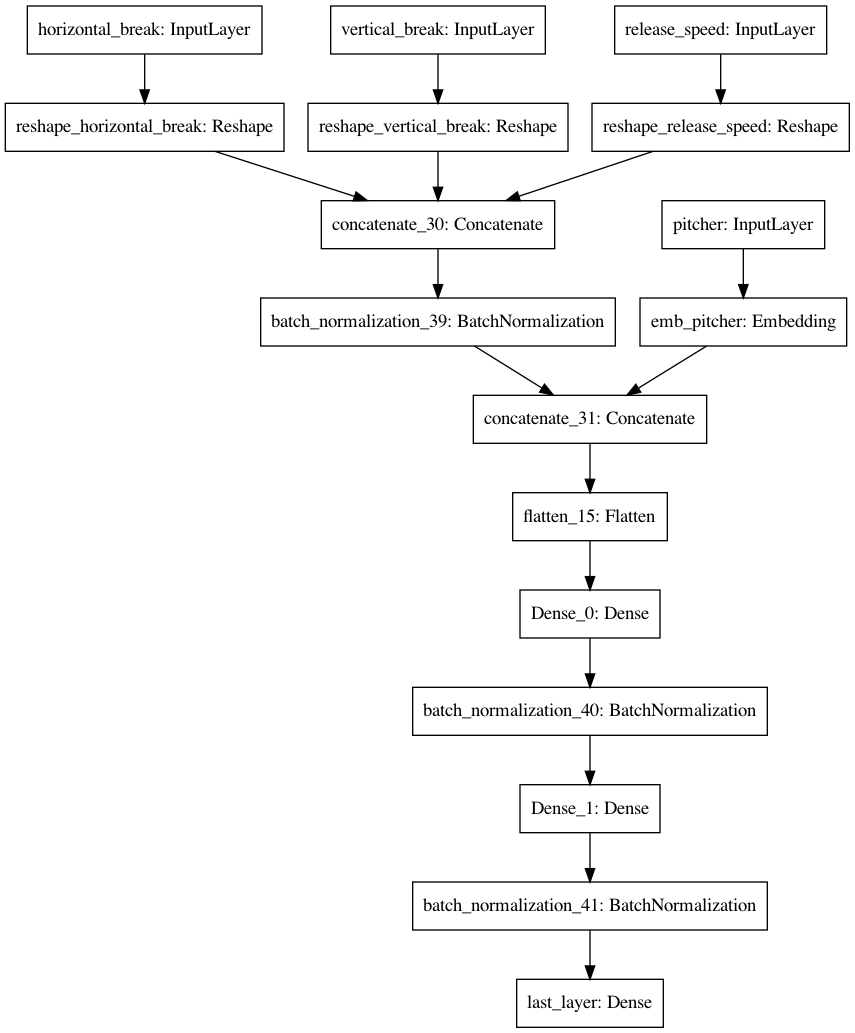

In [233]:
plot_model(model)

# Preparing the data <a name="data"></a>

In [11]:
# factorize pitcher_id
pitcher_id, pitcher_mapping = baseball.pitcher.factorize()

In [237]:
# factorize and one-hot encode the target
target, target_mapping = baseball.pitch_type.factorize()
target = to_categorical(target)

In [239]:
data = pd.DataFrame(np.concatenate( (baseball[continuous_cols], pitcher_id.reshape(-1,1)), axis = 1))

In [240]:
# Create train, validation, test sets
np.random.seed(0)
train, val = train_test_split(data, test_size=0.2)
val, test = train_test_split(val, test_size=0.5)

x_train = [train.to_numpy()[:,i] for i in range(train.shape[1])]
y_train = target[train.index,]

x_val = [val.to_numpy()[:,i] for i in range(val.shape[1])]
y_val = target[val.index,]

x_test = [test.to_numpy()[:,i] for i in range(test.shape[1])]
y_test = target[test.index,]

In [241]:
x_train

[array([ 0.43636949, -0.38606667, -0.82433096, ..., -1.10973333,
        -0.48209167, -1.69309243]),
 array([-0.1934538 ,  1.6233    ,  1.49283703, ...,  0.97973333,
         1.51006667,  0.74696423]),
 array([86.3, 94.2, 94.6, ..., 82.2, 88.3, 84.7]),
 array([778., 219., 265., ..., 302., 583., 298.])]

In [242]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [243]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2887608, 9)
(360951, 9)
(360951, 9)


# Compiling and fitting the model <a name="compile"></a>

In [244]:
# Compile the model
LEARNING_RATE = 1e-4
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Note that there are tons of parameters to be learned in the embedding layer. It grows linearly with the embedding dimension. In our case, since we have 1523 unique pitchers and 50 dimensions, we have: $(1523+1) * 50 = 76200$ parameters to learn. The $+1$ is for unseen pitcher in the training set.

In [245]:
model.summary()

Model: "PitchNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
horizontal_break (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
vertical_break (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
release_speed (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_horizontal_break (Resha (None, 1, 1)         0           horizontal_break[0][0]           
___________________________________________________________________________________________

### Here I fit the model with 20 epochs with a batch size of 2000. I also set an early stopping callback.

In [246]:
# Define Callbacks
# Early stopping
PATIENCE = 3
early_stopping_monitor = EarlyStopping(patience=PATIENCE)

In [247]:
# Fit the model
NUM_EPOCHS = 20
BATCH_SIZE = 2000

model.fit(x_train, y_train, epochs=NUM_EPOCHS, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stopping_monitor])

Epoch 1/20
1444/1444 [==============================] - 4s 3ms/step - loss: 1.0241 - accuracy: 0.6986 - val_loss: 0.5165 - val_accuracy: 0.8814
Epoch 2/20
1444/1444 [==============================] - 4s 3ms/step - loss: 0.3557 - accuracy: 0.9103 - val_loss: 0.2625 - val_accuracy: 0.9251
Epoch 3/20
1444/1444 [==============================] - 4s 3ms/step - loss: 0.2226 - accuracy: 0.9303 - val_loss: 0.1974 - val_accuracy: 0.9342
Epoch 4/20
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1816 - accuracy: 0.9368 - val_loss: 0.1720 - val_accuracy: 0.9385
Epoch 5/20
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1641 - accuracy: 0.9399 - val_loss: 0.1599 - val_accuracy: 0.9403
Epoch 6/20
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1552 - accuracy: 0.9415 - val_loss: 0.1534 - val_accuracy: 0.9420
Epoch 7/20
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1497 - accuracy: 0.9429 - val_loss: 0.1493 - val_accuracy:

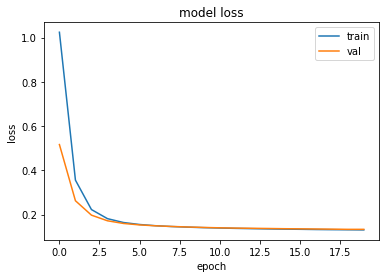

In [248]:
# Plot model loss over 20 epochs
from matplotlib import pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

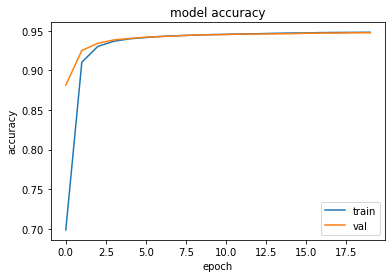

In [249]:
# Plot model accuracy over 20 epochs
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

The model achieves a 0.948 accuracy on the test set:

In [250]:
# test set accuracy
model.evaluate(x_test, y_test)

11280/11280 [==============================] - 4s 384us/step - loss: 0.1306 - accuracy: 0.9486


[0.13061673939228058, 0.9485968947410583]

In [251]:
model.save('model')

INFO:tensorflow:Assets written to: model_1/assets


# Grid search for best structure <a name="grid"></a>
We are also interested in finding the best structure, i.e. the number of nodes of the hidden layers, the number of hidden layers, and the dimension of the embedding layer.

In [83]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 2000
PATIENCE = 3

embedding_dim_grid = [25, 50, 75]
hidden_layer_dim_grid = [[15],[30],[30,15]]

optimizer = Adam(learning_rate=LEARNING_RATE)
early_stopping_monitor = EarlyStopping(patience=PATIENCE)
best_accuracy = -np.inf

for i in embedding_dim_grid:
    for j in hidden_layer_dim_grid:
        model = make_PitchNet(n_pitch_type, 
                      n_pitcher,
                      continuous_cols, 
                      embedding_dim = i, 
                      hidden_layer_dim = j)
        model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        model.fit(x_train, y_train, epochs=NUM_EPOCHS, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stopping_monitor],verbose = False)
        print('embedding_dim = {}, hidden_layer_dim = {}'.format(i,j))
        test_acc = model.evaluate(x_test, y_test)
        if test_acc[1] > best_accuracy:
            best_accuracy = test_acc[1]
            best_params = {'embedding_dim': i, 'hidden_layer_dim': j}

embedding_dim = 25, hidden_layer_dim = [15]
11280/11280 [==============================] - 4s 353us/step - loss: 0.1598 - accuracy: 0.9389
embedding_dim = 25, hidden_layer_dim = [30]
11280/11280 [==============================] - 4s 353us/step - loss: 0.1428 - accuracy: 0.9450
embedding_dim = 25, hidden_layer_dim = [30, 15]
11280/11280 [==============================] - 4s 372us/step - loss: 0.1343 - accuracy: 0.9482
embedding_dim = 50, hidden_layer_dim = [15]
11280/11280 [==============================] - 4s 356us/step - loss: 0.1582 - accuracy: 0.9397
embedding_dim = 50, hidden_layer_dim = [30]
11280/11280 [==============================] - 4s 357us/step - loss: 0.1389 - accuracy: 0.9460
embedding_dim = 50, hidden_layer_dim = [30, 15]
11280/11280 [==============================] - 4s 385us/step - loss: 0.1297 - accuracy: 0.9488
embedding_dim = 75, hidden_layer_dim = [15]
11280/11280 [==============================] - 4s 364us/step - loss: 0.1534 - accuracy: 0.9409
embedding_dim = 75,

In [106]:
best_params

{'embedding_dim': 75, 'hidden_layer_dim': [30, 15]}

The grid search for optimal structure shows that a higher embeddding dimension leads to a higher accuracy, however the increase is marginal, so it's probably not worth increasing the embedding dimension. On the other hand, the number of nodes (30 v.s. 15) in the hidden layer seems to have a larger effect on the accuracy. Having a deeper structure (2 layers v.s. 1 layer) also seems to gives a marginal increase in accuracy.

# Conclusion <a name="con"></a>
In this notebook, I successfully implemented the PitchNet for a 9-class pitch classification task. Although the PitchNet has a fairly simple structure, it is already able to achieve a 95% accuracy. The model does not seem to overfit given its simple structure. However, some dropout layers after the embedding layer or the hidden layers could also be added. 
